In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import rsfuncs as rs

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from scipy.signal import savgol_filter
from pandas.tseries.offsets import MonthEnd

register_matplotlib_converters()
ee.Initialize()

In [6]:
# Load cv shapefile
cvsa = gp.read_file("../shape/cv.shp")
crs = {"init":"epsg:4326"}
cvsa.crs = crs

# CVW shapefile 
cvw = gp.read_file("../shape/cv_hu6.shp")

# irrigated / non irrigated areas 
# irrigated = gp.read_file("../shape/irrigated.shp")
# non_irrigated = gp.read_file("../shape/non_irrigated.shp")

# SSJT basins 
# s = gp.read_file("../Shape/1802_4.shp")
# sj = gp.read_file("../Shape/1804_4.shp")
# t = gp.read_file("../Shape/1803_4.shp")

# grace footprint
grace_sa = gp.read_file("../shape/argus_grace.shp")

# Casgem wells 
casgem = gp.read_file("../shape/casgem_wells.shp")
casgem = gp.sjoin(casgem,cvsa, op ='within')

/anaconda3/envs/gis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [3]:
# Read and format data 

In [45]:
# Load preprocessed RS Data
df = pd.read_csv("../data/WRR_cv_balance_fin.csv")
cvwdf = pd.read_csv("../data/WRR_cvw_balance_fin.csv")
cv_et = pd.read_csv("../data/et_irrigated.csv")
ssebop_et =  pd.read_csv("../data/et.csv")

df = rs.col_to_dt(df)
cvwdf = rs.col_to_dt(cvwdf)
cv_et = rs.col_to_dt(cv_et)
ssebop_et = rs.col_to_dt(ssebop_et)

ssebop_et.index = ssebop_et.index+ MonthEnd(1)

In [48]:
# Replace master df columns with processed ET cols
for i in cv_et.columns:
    df[i] = cv_et[i]

In [49]:
# Multiply by crop coefficients in place 
for i in [df.nldas_etr, df.gldas_etr, df.gmet_eto, df.gmet_etr, df.modis_pet, df.tc_pet]:
    i = i * df.et_multiplier

In [50]:
df = pd.merge(df, ssebop_et, left_index = True, right_index = True)

In [52]:
# calculate means for the CV (df)
df["aet_mean"] = np.mean([df['fldas_aet'], df['gldas_aet'],df['modis_aet'],df['tc_aet']],axis = 0)
df["pet_mean"] = np.mean([df['modis_pet'],df['tc_pet'],df['gmet_eto'],df['gmet_etr'], df['gldas_etr'], df['nldas_etr']],axis = 0) 
# df["pet_mean"] = np.mean([df['modis_pet'],df['tc_pet'],df['gmet_eto'],df['gmet_etr'], df['gldas_etr'],df['nldas_etr']],axis = 0) # We drop GLDAS and NLDAS as they are biased high for the CV 
df["p_mean"] = np.mean([df['p_prism'], df['p_chirps'],df['p_persiann'],df['p_trmm'],df['p_daymet']],axis = 0)
df['sm_mean'] = np.mean([df['gldas_sm'], df['tc_sm'], df["gldas_m"]],axis = 0)
df['r_mean'] = np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
# Compute the effective runoff as mean(cvw_runoff) - mean(cv_runoff)
df['r_eff'] = np.mean([cvwdf['gldas'], cvwdf['fldas_r'], cvwdf["tc_r"]],axis = 0) - np.mean([df['gldas'], df['fldas_r'], df["tc_r"], df['q_in']],axis = 0)
# df['et_eff'] = np.mean([df.modis_aet + df.modis_pet, df.tc_aet + df.tc_pet, df.gldas_aet + df.gldas_etr], axis = 0)#np.sum([et_data.aet_mean, et_data.pet_mean], axis = 0)
df['et_eff'] = np.sum([df.aet_mean, df.pet_mean], axis = 0)#np.sum([et_data.aet_mean, et_data.pet_mean], axis = 0)

# Calc means for the CV Watershed (cvwdf)
cvwdf["aet_mean"] = np.mean([cvwdf['fldas_aet'], cvwdf['gldas_aet'],cvwdf['modis_aet'],cvwdf['tc_aet']],axis = 0)
cvwdf["p_mean"] = np.mean([cvwdf['p_prism'], cvwdf['p_chirps'],cvwdf['p_persiann'],cvwdf['p_trmm'],cvwdf['p_daymet']],axis = 0)
cvwdf['sm_mean'] = np.mean([cvwdf['gldas_sm'], cvwdf['tc_sm'], cvwdf["gldas_m"]],axis = 0)
cvwdf['swe_mean'] =  np.mean([cvwdf['fldas_swe'],cvwdf['gldas_swe']], axis = 0)
cvwdf["cv_pet_mean"] = np.mean([df['modis_pet'], df['tc_pet'], df['gmet_eto'], df['gmet_etr'], df['gldas_etr'], df['nldas_etr']],axis = 0)

cvwdf['et_eff'] = np.sum([df['pet_mean'],df['aet_mean'], cvwdf['aet_mean']],axis = 0)


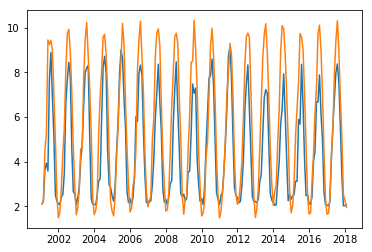

In [64]:
plt.plot(df.ssebop_cv+2)
plt.plot(df.et_eff)

In [65]:
# Equations 1 and 2 in paper
df["cv_ds"] = df.p_mean - df.ssebop_cv - df.q_out + df.q_in  - df.sm_mean.diff() - df.storage_km3.diff() 
cvwdf["cvw_ds"] = cvwdf.p_mean - df.ssebop_cvws - cvwdf.q_out  - cvwdf.sm_mean.diff() - cvwdf.storage_km3.diff() - cvwdf.swe_mean.diff()

# Difference storage estimates to 2001 - 2006 baseline 
df.cv_ds = df.cv_ds - np.mean(df.cv_ds[:60])
cvwdf.cvw_ds = cvwdf.cvw_ds - np.mean(cvwdf.cvw_ds[:60])

In [66]:
# Grace data
# grace = pd.read_csv("../data/grace_extended.csv")
# grace = rs.col_to_dt(grace)
# grace['adj'] = grace['ts_savgol']
# grace['adj'] = grace.grace.interpolate(method="polynomial", order = 2)

# Wells data (processed by zihan using Faunt 2009 SY values )
wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)

wells['ds_km3'] = wells[wells.columns[-1]] * 55000 * 1e-5

# c2vsim storage data 
c2vs = pd.read_csv("../data/all_data_cv.csv")
c2vs.ds = c2vs.s.diff()
df['c2vsim'] = c2vs.s.diff().values[-len(df):]

NameError: name 'grace' is not defined

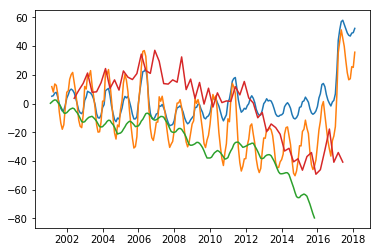

In [69]:
# Equations 1 and 2 in paper
# df["cv_ds"] = df.p_mean - df.et_eff - df.q_out + df.q_in + df.r_mean - df.sm_mean.diff() - df.storage_km3.diff() 
# cvwdf["cvw_ds"] = cvwdf.p_mean - cvwdf.et_eff - cvwdf.q_out  - cvwdf.sm_mean.diff() - cvwdf.storage_km3.diff() - cvwdf.swe_mean.diff()

# plt.plot(np.cumsum(df.cv_diff))
plt.plot(np.cumsum(df.cv_ds))

# plt.plot(np.cumsum(cvwdf.cvw_diff))
plt.plot(np.cumsum(cvwdf.cvw_ds))

plt.plot(np.cumsum(df.c2vsim))
plt.plot(wells.ds_km3)
plt.plot(grace.adj)
plt.legend()

plt.show()

NameError: name 's' is not defined

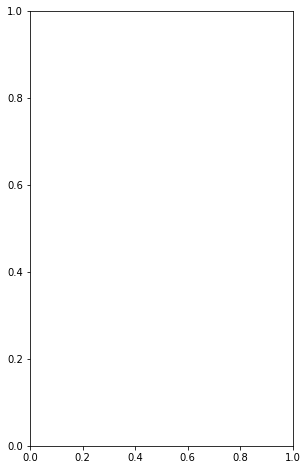

In [68]:
plt.figure(figsize=(16, 8))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
ax = plt.subplot(G[:, 0])

# Plot the huc4s
s.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
sj.plot(ax = ax, color = 'blue', alpha = 0.1, edgecolor = "black")
t.plot(ax = ax, color = 'blue', alpha = 0.1,  edgecolor = "black")

# Rivers, CV, canals, CA, irrigated, non irrigated
# rivers.plot(ax = ax, color = "blue", label = "major rivers")
cvsa.plot(ax = ax, color = "green", edgecolor = "black", alpha = 0.5, label = "central valley")
# canals.plot(ax = ax, color = "red", edgecolor = "none", alpha = 0.5, label = "CVP canals / aqueducts")
casgem.plot(ax = ax, marker = ".", markersize = 0.1, color = 'gray')
# irrigated.plot(ax = ax, color = "green", alpha = 0.7, label = "irrigated")
# non_irrigated.plot(ax = ax, color = "yellow", alpha = 0.7, label = 'non-irrigated')
grace_sa.plot(ax = ax, color = "lightcoral", alpha = 0.1, edgecolor = 'black')

plt.ylabel('latitude', size = 15)
plt.xlabel('longitude', size = 15)

# Plot the timeseries
axes_4 = plt.subplot(G[0:2, 1:])
axes_4.plot(df.index, np.cumsum(df.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(cvwdf.cvw_ds), color="blue",alpha = 0.5, label = "CV Wshed $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(df.c2vsim), color="green", label = "C2VSIM")
# axes_4.plot(df2.index, np.cumsum(df2.ds), color="red", label = "CVW $\Delta S_{gw}$ ")
axes_4.plot(wells.index, wells.ds_km3, color="gray", label = "Wells ($S_y$ Faunt (2009))")
axes_4.plot(grace.index, grace.adj, color="lightcoral", linewidth = 3, alpha = .5, label = "GRACE")

axes_4.set_ylim(-130,75)
axes_4.set_xlim(df.index[0],df.index[-1])

axes_4.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_4.legend(loc = "lower left",  prop={'size':18})

plt.grid(True)
G.update(wspace=0.4, hspace=0.3) # set the spacing between axes. 

# plt.tight_layout()
plt.show()

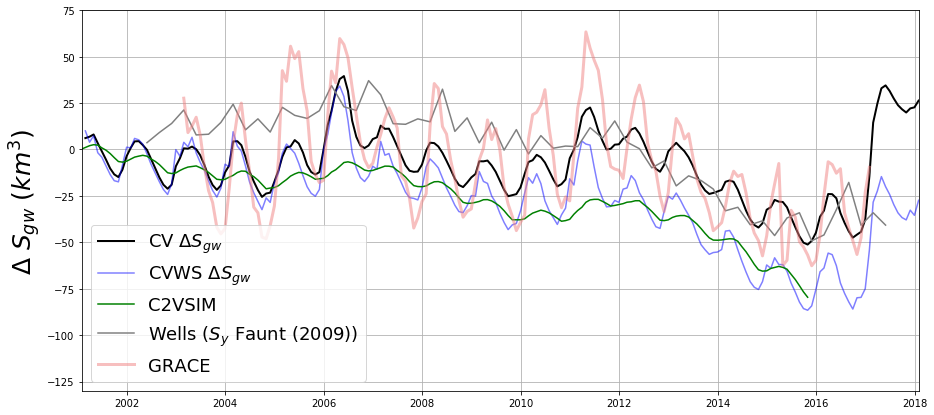

In [154]:

# Plot the timeseries
plt.figure(figsize = (15,7))
axes_4 = plt.subplot(1,1,1)
axes_4.plot(df.index, np.cumsum(df.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(cvwdf.cvw_ds), color="blue",alpha = 0.5, label = "CVWS $\Delta S_{gw}$")
axes_4.plot(df.index, np.cumsum(df.c2vsim), color="green", label = "C2VSIM")
# axes_4.plot(df2.index, np.cumsum(df2.ds), color="red", label = "CVW $\Delta S_{gw}$ ")
axes_4.plot(wells.index, wells.ds_km3, color="gray", label = "Wells ($S_y$ Faunt (2009))")
axes_4.plot(grace.index, grace.adj, color="lightcoral", linewidth = 3, alpha = .5, label = "GRACE")

axes_4.set_ylim(-130,75)
axes_4.set_xlim(df.index[0],df.index[-1])

axes_4.set_ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
axes_4.legend(loc = "lower left",  prop={'size':18})

plt.grid(True)
G.update(wspace=0.4, hspace=0.3) # set the spacing between axes. 


In [155]:
# Do triple collocation on grace, wells, rs model

def calc_tc_error(x,y,z):
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    return ((src - np.mean(src)) /
            np.std(src)) * np.std(ref) + np.mean(ref)

In [156]:
from itertools import combinations

tc_dat = [np.cumsum(df.cv_ds),  np.cumsum(df.c2vsim),wells.ds_km3, grace.adj]

combos=combinations([0,1,2,3], 3) 

out = {0:[], # rs
       1:[], # wells
       2:[], # c2vsim
       3:[]  # grace 
        }

# out = {}

for idx,i in enumerate(combos):
    x = tc_dat[i[0]]
    y = tc_dat[i[1]]
    z = tc_dat[i[2]]
    
    y_scaled = scale_to_ref(y,x)
    z_scaled = scale_to_ref(z,x)

    e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)
    
    errors = calc_tc_error(x, y_scaled, z_scaled)
    
    for idx,j in enumerate(i):
        out[j].append(errors[idx])
        
D = {k:np.array(v).mean() for k,v in out.items() }
maxs = {k:np.array(v).max() for k,v in out.items() }
mins = {k:np.array(v).min() for k,v in out.items() }
stds = {k:np.array(v).std() for k,v in out.items() }

In [157]:
# Merge all the DFS and create a mean error 

merged1 = pd.merge(df, wells, left_index=True, right_index=True, how = "outer")
merged2 = pd.merge(merged1, grace, left_index=True, right_index=True, how = "outer")

for idx,x in enumerate(["cv_ds",'ds_km3', "c2vsim",'adj']):
    merged2[x+"_max"] = merged2[x] + D[idx]
    merged2[x+"_min"] = merged2[x] - D[idx]
    
merged2['cs'] = np.cumsum(df.cv_ds)
merged2['c2v_cs'] = np.cumsum(df.c2vsim)
merged2['ds_mean'] = np.nanmean(merged2[["cs",'ds_km3', "c2v_cs",'adj']], axis = 1)
merged2['upper_bound'] = np.array(list(D.values())).mean()
merged2['lower_bound'] = np.array(list(D.values())).mean()

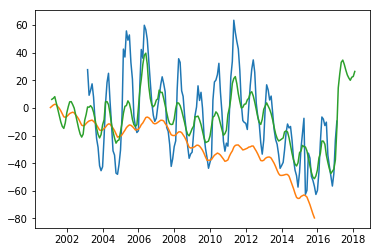

In [158]:
plt.plot(merged2.adj)
plt.plot(np.cumsum(merged2.c2vsim))
plt.plot(np.cumsum(merged2.cv_ds))

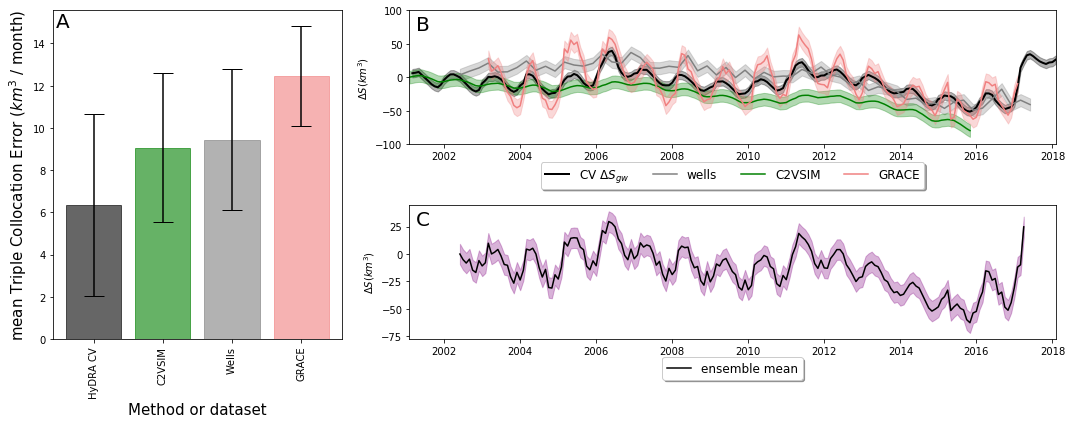

In [160]:
# Plot the TC bar chart and time series
plt.figure(figsize = (15,6))

G = gridspec.GridSpec(4, 3)

# Plot the basemaps
ax = plt.subplot(G[:, 0])

bars = plt.bar(range(len(D)), list(D.values()),yerr=list(stds.values()), ecolor='black', capsize=10, alpha =0.6, align='center')
bars[0].set_color('black')
bars[1].set_color('green')
bars[2].set_color('gray')
bars[-1].set_color('lightcoral')
plt.xticks(range(len(D)), ["HyDRA CV",  "C2VSIM","Wells",  "GRACE"], rotation='vertical')
plt.ylabel("mean Triple Collocation Error ($km^3$ / month)", size = 15)
plt.xlabel("Method or dataset", size = 15)

ax.annotate("A", xy=(0.01, 0.95), xycoords="axes fraction", size = 20)


# ax2 = plt.subplot(G[:, 0])
axes_2 = plt.subplot(G[0:2, 1:])
axes_2.plot(merged2.index, np.cumsum(merged2.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$")
axes_2.fill_between(merged2.index, np.cumsum(merged2.cv_ds)+D[0], np.cumsum(merged2.cv_ds)-D[0], color="black", alpha = 0.3)
# axes_2.fill_between(merged2.index, np.cumsum(merged2.cv_ds)+maxs[0], np.cumsum(merged2.cv_ds)-maxs[0], color="black", alpha = 0.1)

axes_2.plot(wells.index,wells.ds_km3, color="gray", label = "wells")
axes_2.fill_between(wells.index, wells.ds_km3+D[1],wells.ds_km3-D[1], color="gray", alpha = 0.3)
# axes_2.fill_between(wells.index, wells.ds_km3+maxs[1],wells.ds_km3-maxs[1], color="gray", alpha = 0.1)

axes_2.plot(merged2.index, np.cumsum(merged2.c2vsim), color="green", label = "C2VSIM")
axes_2.fill_between(merged2.index, np.cumsum(merged2.c2vsim)+D[2], np.cumsum(merged2.c2vsim)-D[2], color="green", alpha = 0.3)
# axes_2.fill_between(merged2.index, np.cumsum(merged2.c2vsim)+maxs[2], np.cumsum(merged2.c2vsim)-maxs[2], color="green", alpha = 0.1)

axes_2.plot(grace.index, grace.adj, color="lightcoral", label = "GRACE")
axes_2.fill_between(grace.index, grace.adj+D[3],  grace.adj-D[3], color="lightcoral", alpha = 0.3)
# axes_2.fill_between(grace.index, grace.adj+maxs[3],  grace.adj-maxs[3], color="lightcoral", alpha = 0.1)

axes_2.set_ylim([-100,100])
axes_2.set_xlim(merged2.index[0],merged2.index[-1])
axes_2.set_ylabel("$\Delta S (km^3)$")
axes_2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

axes_2.annotate("B", xy=(0.01, 0.85), xycoords="axes fraction", size = 20)

axes_3 = plt.subplot(G[2:4, 1:])

axes_3.plot(merged2.ds_mean[16:-10], color = "black", label = 'ensemble mean')
axes_3.fill_between(merged2.index[16:-10], merged2.ds_mean[16:-10] + merged2.upper_bound[16:-10], merged2.ds_mean[16:-10] - merged2.lower_bound[16:-10] ,color = "purple", alpha = 0.3)
axes_3.set_xlim(merged2.index[0],merged2.index[-1])
axes_3.set_ylabel("$\Delta S (km^3)$")
axes_3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
axes_3.annotate("C", xy=(0.01, 0.85), xycoords="axes fraction", size = 20)

plt.tight_layout()
plt.show()

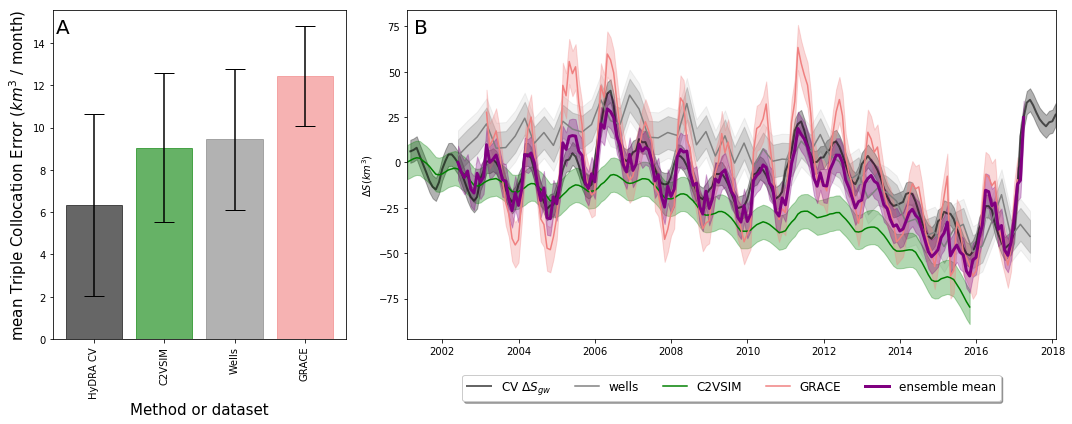

In [161]:
# Plot the TC bar chart and time series
plt.figure(figsize = (15,6))

G = gridspec.GridSpec(4, 3)

# Plot the basemaps
ax = plt.subplot(G[:, 0])

bars = plt.bar(range(len(D)), list(D.values()),yerr=list(stds.values()), ecolor='black', capsize=10, alpha =0.6, align='center')
bars[0].set_color('black')
bars[1].set_color('green')
bars[2].set_color('gray')
bars[-1].set_color('lightcoral')
plt.xticks(range(len(D)), ["HyDRA CV",  "C2VSIM","Wells",  "GRACE"], rotation='vertical')
plt.ylabel("mean Triple Collocation Error ($km^3$ / month)", size = 15)
plt.xlabel("Method or dataset", size = 15)

ax.annotate("A", xy=(0.01, 0.93), xycoords="axes fraction", size = 20)


axes_2 = plt.subplot(G[0:4, 1:])
axes_2.plot(merged2.index, np.cumsum(merged2.cv_ds), color="black", linewidth = 2, label = "CV $\Delta S_{gw}$", alpha = 0.6)
axes_2.fill_between(merged2.index, np.cumsum(merged2.cv_ds)+D[0], np.cumsum(merged2.cv_ds)-D[0], color="black", alpha = 0.3)
# axes_2.fill_between(merged2.index, np.cumsum(merged2.cv_ds)+maxs[0], np.cumsum(merged2.cv_ds)-maxs[0], color="black", alpha = 0.1)

axes_2.plot(wells.index,wells.ds_km3, color="gray", label = "wells")
axes_2.fill_between(wells.index, wells.ds_km3+D[1],wells.ds_km3-D[1], color="gray", alpha = 0.3)
axes_2.fill_between(wells.index, wells.ds_km3+maxs[1],wells.ds_km3-maxs[1], color="gray", alpha = 0.1)

axes_2.plot(merged2.index, np.cumsum(merged2.c2vsim), color="green", label = "C2VSIM")
axes_2.fill_between(merged2.index, np.cumsum(merged2.c2vsim)+D[2], np.cumsum(merged2.c2vsim)-D[2], color="green", alpha = 0.3)
# axes_2.fill_between(merged2.index, np.cumsum(merged2.c2vsim)+maxs[2], np.cumsum(merged2.c2vsim)-maxs[2], color="green", alpha = 0.1)

axes_2.plot(grace.index, grace.adj, color="lightcoral", label = "GRACE")
axes_2.fill_between(grace.index, grace.adj+D[3],  grace.adj-D[3], color="lightcoral", alpha = 0.3)
# axes_2.fill_between(grace.index, grace.adj+maxs[3],  grace.adj-maxs[3], color="lightcoral", alpha = 0.1)

# axes_2.set_ylim([-100,100])
# axes_2.set_xlim(merged2.index[0],merged2.index[-1])
# axes_2.set_ylabel("$\Delta S (km^3)$")
# axes_2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

axes_2.annotate("B", xy=(0.01, 0.93), xycoords="axes fraction", size = 20)

# axes_3 = plt.subplot(G[2:4, 1:])

axes_2.plot(merged2.ds_mean[16:-10], color = "purple",linewidth =3, label = 'ensemble mean')
axes_2.fill_between(merged2.index[16:-10], merged2.ds_mean[16:-10] + merged2.upper_bound[16:-10], merged2.ds_mean[16:-10] - merged2.lower_bound[16:-10] ,color = "purple", alpha = 0.3)
axes_2.set_xlim(merged2.index[0],merged2.index[-1])
axes_2.set_ylabel("$\Delta S (km^3)$")

axes_2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

# axes_2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=7, prop = {"size":12})
# axes_2.annotate("C", xy=(0.01, 0.85), xycoords="axes fraction", size = 20)

plt.tight_layout()
plt.show()

In [162]:
# Fit trendlines during droughts 
df = pd.merge(df,wells, how = "outer", left_index = True, right_index = True)
df = pd.merge(df,grace, how = "outer", left_index = True, right_index = True)
df.ds_km3 = df.ds_km3.interpolate(method='polynomial', order=2)

In [163]:
# Droughts
idx0709 = range(69,105)
idx1216 = range(129,129+48)
# Wet winters
idx1617 =range(177,201)
idx0911 = range(105,105+24)
idx0506 = range(57,45+24)

In [164]:
def fit_trend(df_column, index):
    z = np.polyfit(x=df_column.iloc[index], y=np.arange(0,len(index)), deg=1)
    p = np.poly1d(z)
    ds_trend = p(df_column.iloc[index])
    x = np.arange(len(index))
    fit = np.polyfit(x, df_column.iloc[index], 1)
    fit_fn = np.poly1d(fit)
    annual_slope = (fit_fn(x)[-1] - fit_fn(x)[0]) / 2
    
    return fit_fn, x, annual_slope

In [165]:
fns1 = []
xs1 = []
slopes1 = []

for i in [np.cumsum(df.cv_ds), np.cumsum(df.c2vsim), df.ds_km3, df.adj, np.cumsum(cvwdf.cvw_ds)]:
    fn,x,sl = fit_trend(i, idx0709)
    fns1.append(fn)
    xs1.append(x)
    slopes1.append(str(round(sl,0))[:-2])
    

In [166]:
fns2 = []
xs2 = []
slopes2 = []

for i in [np.cumsum(df.cv_ds), np.cumsum(df.c2vsim), df.ds_km3, df.adj, np.cumsum(cvwdf.cvw_ds)]:
    fn,x,sl = fit_trend(i, idx1216)
    fns2.append(fn)
    xs2.append(x)
    slopes2.append(str(round(sl,1))[:-2])
    

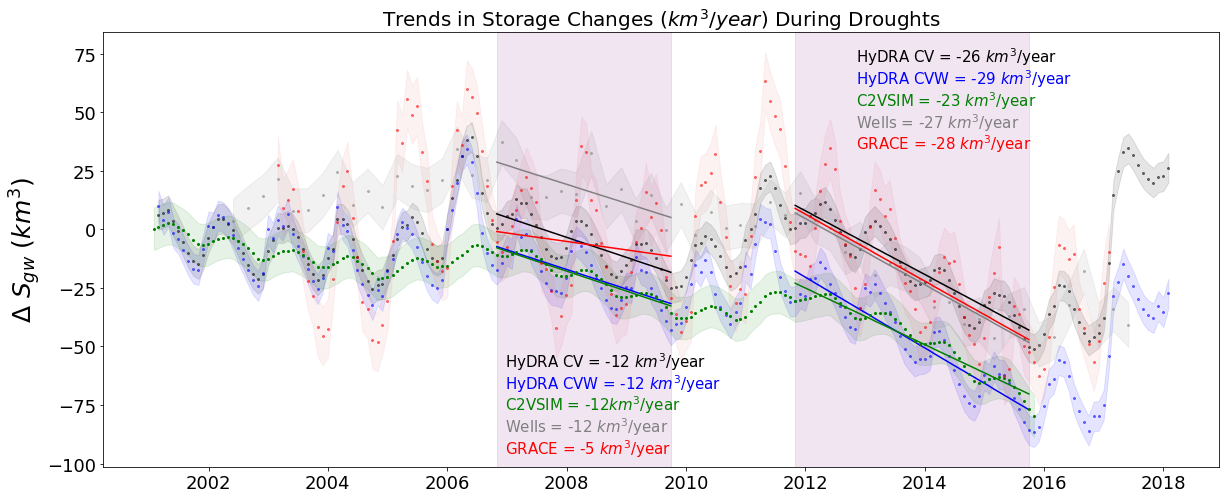

In [167]:
plt.figure(figsize = (20,8))
plt.title("Trends in Storage Changes ($km^3/year$) During Droughts", size = 20)

# RS method CV
plt.plot(df.index[idx0709], fns1[0](xs1[0]), color = 'black', label = "HyDRA CV trendlines")
plt.plot(df.index[idx1216], fns2[0](xs2[0]), color = "black")
plt.plot(df.index, np.cumsum(df.cv_ds), "o",color = 'black', ms = 2, alpha = 0.5, label = "HyDRA CV datapoints")
plt.fill_between(df.index, np.cumsum(df.cv_ds)+D[0], np.cumsum(df.cv_ds)-D[0], color="black", alpha = 0.1)

# CVW
plt.plot(df.index[idx0709], fns1[-1](xs1[-1]), color = 'blue', label = "HyDRA CVW trendlines")
plt.plot(df.index[idx1216], fns2[-1](xs2[-1]), color = "blue")
plt.plot(df.index, np.cumsum(cvwdf.cvw_ds), "o",color = 'blue', ms = 2,alpha = 0.5, label = "HyDRA CVW datapoints")
plt.fill_between(df.index, np.cumsum(cvwdf.cvw_ds)+D[0], np.cumsum(cvwdf.cvw_ds)-D[0], color="blue", alpha = 0.1)

#C2vsim
plt.plot(df.index[idx0709], fns1[1](xs1[1]), "g", label = 'C2VSIM trendlines')
plt.plot(df.index[idx1216], fns2[1](xs2[1]), color = "green")
plt.plot(df.index, np.cumsum(df.c2vsim), 'go', ms=2, label = "C2VSIM datapoints")
plt.fill_between(df.index, np.cumsum(df.c2vsim)+D[1], np.cumsum(df.c2vsim)-D[1], color="green", alpha = 0.1)

# Wells
plt.plot(df.index[idx0709], fns1[2](xs1[2]),color = 'gray', label = "Wells trendlines")
plt.plot(df.index[idx1216], fns2[2](xs2[2]), color = "gray")
plt.plot(wells.index, wells.ds_km3, 'o', color = 'gray', ms=2, alpha = 0.5, label = "Wells datapoints")
plt.fill_between(wells.index, wells.ds_km3+D[2],wells.ds_km3-D[2], color="gray", alpha = 0.1)

# GRACE 
plt.plot(df.index[idx0709], fns1[3](xs1[3]), color = 'red', label = "GRACE trendline")
plt.plot(df.index[idx1216], fns2[3](xs2[3]), color = 'red')
plt.plot(df.index, df.adj, 'o', ms=2, color = "red", alpha = 0.5, label = "GRACE datapoints")
plt.fill_between(df.index, df.adj+D[3],df.adj-D[3], color="lightcoral", alpha = 0.1)


# Labels and legend 
plt.ylabel('$\Delta$ $S_{gw}$ ($km^3$)', size = 25) 
# plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.9), fancybox=True, shadow=True, ncol=1, prop = {"size":12})
plt.tick_params(axis='both', which='major', labelsize=18)


# plt.annotate("Oct '07 - Oct 09 $ km^3 / yr$", xy=(0.354, 0.28), xycoords="axes fraction", size = 16)
plt.annotate("HyDRA CV = {} $km^3$/year".format(slopes1[0]),xy=(0.36, 0.23), xycoords="axes fraction", size = 15)
plt.annotate("HyDRA CVW = {} $km^3$/year".format(slopes1[-1]),xy=(0.36, 0.18),color = "blue", xycoords="axes fraction", size = 15)
plt.annotate("C2VSIM = {}$km^3$/year".format(slopes1[1]),xy=(0.36, 0.13), color = 'green', xycoords="axes fraction", size = 15)
plt.annotate("Wells = {} $km^3$/year".format(slopes1[2]),xy=(0.36, 0.08), color = 'gray', xycoords="axes fraction", size = 15)
plt.annotate("GRACE = {} $km^3$/year".format(slopes1[3]),xy=(0.36, 0.03), color = 'red',xycoords="axes fraction", size = 15)

plt.axvspan(df.index[idx0709][0], df.index[idx0709][-1], alpha=0.1, color='purple')
plt.axvspan(df.index[idx1216][0], df.index[idx1216][-1], alpha=0.1, color='purple')

# plt.annotate("Oct '11 - Oct 15 $ km^3 / yr$ ", xy=(0.62, 0.93), xycoords="axes fraction", size = 16)
plt.annotate("HyDRA CV = {} $km^3$/year".format(slopes2[0]),xy=(0.675, 0.93), xycoords="axes fraction", size = 15)
plt.annotate("HyDRA CVW = {} $km^3$/year".format(slopes2[-1]),xy=(0.675, 0.88),color = "blue", xycoords="axes fraction", size = 15)
plt.annotate("C2VSIM = {} $km^3$/year".format(slopes2[1]),xy=(0.675, 0.83), color = 'green', xycoords="axes fraction", size = 15)
plt.annotate("Wells = {} $km^3$/year".format(slopes2[2]),xy=(0.675, 0.78), color = 'gray', xycoords="axes fraction", size = 15)
plt.annotate("GRACE = {} $km^3$/year".format(slopes2[3]),xy=(0.675, 0.73), color = 'red',xycoords="axes fraction", size = 15)

plt.show()

In [168]:
# Now the wet winters: 

In [169]:
fns0911 = []
xs0911 = []
slopes0911 = []

for i in [np.cumsum(df.cv_ds), np.cumsum(df.c2vsim), df.ds_km3, df.adj, np.cumsum(cvwdf.cvw_ds)]:
    fn,x,sl = fit_trend(i, idx0911)
    fns0911.append(fn)
    xs0911.append(x)
    slopes0911.append(str(round(sl,0))[:-2])
    
fns0506 = []
xs0506 = []
slopes0506 = []

for i in [np.cumsum(df.cv_ds), np.cumsum(df.c2vsim), df.ds_km3, df.adj, np.cumsum(cvwdf.cvw_ds)]:
    fn,x,sl = fit_trend(i, idx0506)
    fns0506.append(fn)
    xs0506.append(x)
    slopes0506.append(str(round(sl,0))[:-2])    
    
fns1617 = []
xs1617 = []
slopes1617 = []

for i in [np.cumsum(df.cv_ds), np.cumsum(df.c2vsim), df.ds_km3, df.adj, np.cumsum(cvwdf.cvw_ds)]:
    fn,x,sl = fit_trend(i, idx1617)
    fns1617.append(fn)
    xs1617.append(x)
    slopes1617.append(str(round(sl,0))[:-2])    
    

In [170]:
slopes0911, slopes0406, slopes1517

(['17', '5', '2', '31', '10'],
 ['12', '5', '-1', '21', '5'],
 ['43', 'n', 'n', 'n', '29'])